## Load Mnist Data

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import metrics
from sklearn import cluster

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input

os.environ['KERAS_BACKEND'] = 'TensorFlow'
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data pre-processing
x_train = x_train.astype('float32') / 255. - 0.5       # minmax_normalized
x_test = x_test.astype('float32') / 255. - 0.5         # minmax_normalized
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Kmeans

In [23]:
kmeans_fit = cluster.KMeans(n_clusters = 10).fit(x_train)
cluster_labels = kmeans_fit.labels_

In [26]:
acc_kmeans = metrics.acc(y_train, cluster_labels) 
print acc_kmeans

0.533583333333


## PCA + Kmeans

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [38]:
pca_x = pca.transform(x_test)
kmeans_fit = cluster.KMeans(n_clusters = 10).fit(pca_x)
cluster_labels = kmeans_fit.labels_
acc_pca = metrics.acc(y_test, cluster_labels) 
print acc_pca

0.3945


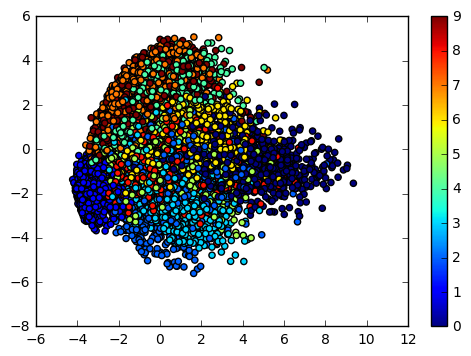

In [39]:
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=y_test)
plt.colorbar()
plt.show()

## AutoEncoder

In [4]:
# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(784,))

In [5]:
# encoder layers
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(input=input_img, output=decoded)

/Users/yehben/anaconda/lib/python2.7/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Elemwise{t..., inputs=/input_1)`
  '` call to the Keras 2 API: ' + signature)


In [6]:
# construct the encoder model for plotting
encoder = Model(input=input_img, output=encoder_output)

/Users/yehben/anaconda/lib/python2.7/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Elemwise{a..., inputs=/input_1)`
  '` call to the Keras 2 API: ' + signature)


In [7]:
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
# training
autoencoder.fit(x_train, x_train,
                nb_epoch=3,
                batch_size=4096,
                shuffle=True)

Epoch 1/3
60000/60000 [==============================] - 2787s - loss: 0.0681    
Epoch 2/3
60000/60000 [==============================] - 2408s - loss: 0.0667    
Epoch 3/3
60000/60000 [==============================] - 2425s - loss: 0.0664    


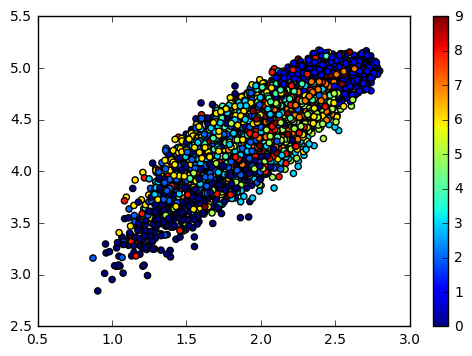

In [13]:
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()


<img src="https://morvanzhou.github.io/static/results/keras/2-6-1.png", width=600, height=600, align='left'>

In [22]:
kmeans_fit = cluster.KMeans(n_clusters = 10).fit(encoded_imgs)
cluster_labels = kmeans_fit.labels_
acc = metrics.acc(y_test, cluster_labels) 
print acc


0.2527


## Denoising AutoEncoder

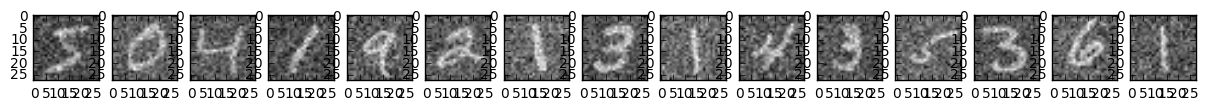

In [36]:
def add_noise(ndarr):
    noise_factor = 0.3
    noisy_ndarr = ndarr + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1.0,
                                                          size=ndarr.shape)
    return noisy_ndarr

noisy_train_img = add_noise(x_train)
noisy_test_img = add_noise(x_test)

fig, axis = plt.subplots(1, 15, figsize=(15, 1))
for i in range(0,15):
    img = np.reshape(noisy_train_img[i],(28,28))
    axis[i].imshow(img, cmap='gray')

plt.show()

In [41]:
# training
autoencoder.fit(noisy_test_img, x_test,
                nb_epoch=5,
                batch_size=1000,
                shuffle=True)

Epoch 1/5
10000/10000 [==============================] - 510s - loss: 0.0586    
Epoch 2/5
10000/10000 [==============================] - 515s - loss: 0.0583    
Epoch 3/5
10000/10000 [==============================] - 538s - loss: 0.0581    
Epoch 4/5
10000/10000 [==============================] - 539s - loss: 0.0579    
Epoch 5/5
10000/10000 [==============================] - 504s - loss: 0.0577    


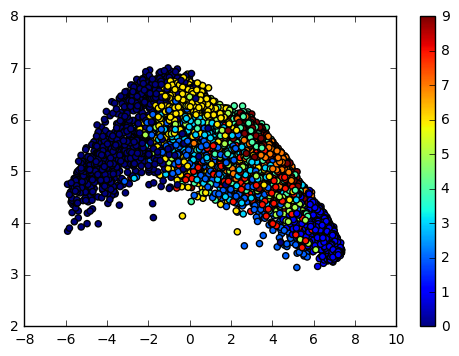

In [42]:
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [43]:
kmeans_fit = cluster.KMeans(n_clusters = 10).fit(encoded_imgs)
cluster_labels = kmeans_fit.labels_
acc = metrics.acc(y_test, cluster_labels) 
print acc


0.2974
